In [29]:
import sqlite3
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import roc_auc_score,confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer

In [2]:
conn =  sqlite3.connect("C://Users//Victor Manuel//Documents//Machine Learning//soccer-analysis//database//database.sqlite")

table_name = "Match"
query = f"SELECT * FROM {table_name};"

match_df = pd.read_sql_query(query, conn)

In [3]:
table_name = "Player"
query = f"SELECT * FROM {table_name};"
player_df = pd.read_sql_query(query,conn)

In [4]:
table_name = 'Team'
query = f"SELECT * FROM {table_name};"
teams_df = pd.read_sql_query(query, conn)

In [5]:
h_players = 'home_player_'
a_players = 'away_player_'
home_players = []
away_players = []

for i in range(11):
    home_players.append(h_players+str(i+1))
    away_players.append(a_players+str(i+1))

features = ['home_team_api_id','away_team_api_id','home_team_goal','away_team_goal'] + home_players + away_players
print(features)

['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11']


In [6]:
def compare_columns(row):
    if row['home_team_goal'] > row['away_team_goal']:
        return 1
    else:
        return 0

In [7]:
#Return only Premier Leage games (league_id = 1729).

match_df = match_df[match_df['league_id'] == 1729]
df = match_df[features]
df = df.dropna()

for i in range(len(home_players)):
    # Merge match_df with player_df
    
    df = df.merge(player_df, left_on = home_players[i], right_on='player_api_id', how= 'left')
    df.drop(columns = [home_players[i],'id','player_api_id','player_fifa_api_id','birthday','height','weight'],inplace = True)
    df.rename(columns={'player_name': 'name_home_player_'+str(i+1)}, inplace = True)

    df = df.merge(player_df, left_on = away_players[i], right_on='player_api_id', how = 'left')
    df.drop(columns = [away_players[i],'id','player_api_id','player_fifa_api_id','birthday','height','weight'],inplace = True)
    df.rename(columns={'player_name': 'name_away_player_'+str(i+1)}, inplace = True)


# Merge match_df with teams_df
df = df.merge(teams_df, left_on = 'home_team_api_id', right_on = 'team_api_id' ,how = 'left')
df.rename(columns = {'team_short_name':'home_team'}, inplace = True)
df.drop(columns = ['home_team_api_id','id','team_api_id','team_fifa_api_id','team_long_name'],inplace = True)

df = df.merge(teams_df, left_on = 'away_team_api_id', right_on = 'team_api_id' ,how = 'left')
df.rename(columns = {'team_short_name':'away_team'},inplace = True)
df.drop(columns = ['away_team_api_id','id','team_api_id','team_fifa_api_id','team_long_name'],inplace = True)

In [8]:
str_col = list(df.dtypes[df.dtypes == 'object'].index)
for col in str_col:
    df[col] = df[col].str.lower().str.replace(' ','_')

In [9]:
df['home_team_win'] = df.apply(compare_columns,axis=1)
df.drop(columns = ['home_team_goal','away_team_goal'],inplace = True)
df.head()

,name_home_player_1,name_away_player_1,name_home_player_2,name_away_player_2,name_home_player_3,name_away_player_3,name_home_player_4,name_away_player_4,name_home_player_5,name_away_player_5,...,name_away_player_8,name_home_player_9,name_away_player_9,name_home_player_10,name_away_player_10,name_home_player_11,name_away_player_11,home_team,away_team,home_team_win
0,edwin_van_der_sar,shay_given,wes_brown,habib_beye,rio_ferdinand,steven_taylor,nemanja_vidic,fabricio_coloccini,patrice_evra,charles_n'zogbia,...,nicky_butt,ryan_giggs,jonas_gutierrez,fraizer_campbell,damien_duff,wayne_rooney,obafemi_martins,mun,new,0
1,manuel_almunia,scott_carson,bacary_sagna,carl_hoefkens,william_gallas,leon_barnett,johan_djourou,abdoulaye_meite,gael_clichy,paul_robinson,...,chris_brunt,samir_nasri,james_morrison,emmanuel_adebayor,marek_cech,nicklas_bendtner,ishmael_miller,ars,wba,1
2,craig_gordon,pepe_reina,pascal_chimbonda,alvaro_arbeloa,nyron_nosworthy,jamie_carragher,danny_collins,sami_hyypiae,phil_bardsley,andrea_dossena,...,damien_plessis,kieran_richardson,yossi_benayoun,el_hadji_diouf,robbie_keane,daryl_murphy,fernando_torres,sun,liv,0
3,robert_green,chris_kirkland,valon_behrami,mario_melchiot,matthew_upson,emmerson_boyce,calum_davenport,maynor_figueroa,lucas_neill,paul_scharner,...,wilson_palacios,matthew_etherington,olivier_kapo,carlton_cole,amr_zaki,dean_ashton,emile_heskey,whu,wig,1
4,tim_howard,paul_robinson,philip_neville,andre_ooijer,joseph_yobo,christopher_samba,joleon_lescott,ryan_nelsen,nuno_valente,stephen_warnock,...,morten_gamst_pedersen,leighton_baines,steven_reid,leon_osman,jason_roberts,aiyegbeni_yakubu,roque_santa_cruz,eve,blb,0


In [10]:
name_h_players = 'name_home_player_'
name_a_players = 'name_away_player_'
name_home_players = []
name_away_players = []

for i in range(11):
    name_home_players.append(name_h_players+str(i+1))
    name_away_players.append(name_a_players+str(i+1))

player_columns = name_home_players + name_away_players
print(player_columns)

['name_home_player_1', 'name_home_player_2', 'name_home_player_3', 'name_home_player_4', 'name_home_player_5', 'name_home_player_6', 'name_home_player_7', 'name_home_player_8', 'name_home_player_9', 'name_home_player_10', 'name_home_player_11', 'name_away_player_1', 'name_away_player_2', 'name_away_player_3', 'name_away_player_4', 'name_away_player_5', 'name_away_player_6', 'name_away_player_7', 'name_away_player_8', 'name_away_player_9', 'name_away_player_10', 'name_away_player_11']


In [11]:
encoded_df = df.copy()

for col in player_columns:
    encoded_df = pd.get_dummies(encoded_df, columns = [col]) 

In [12]:
#Adding the teams
encoded_df['home_team'] = df[['home_team']]
encoded_df['away_team'] = df[['away_team']]

#Encoding the teams
encoded_df = pd.get_dummies(encoded_df, columns = ['home_team'], prefix = 'h_')
encoded_df = pd.get_dummies(encoded_df, columns = ['away_team'], prefix = 'a_')

#Adding the result
encoded_df['home_team_win'] = df[['home_team_win']]

In [13]:
encoded_df.head()

,home_team_win,name_home_player_1_adam_bogdan,name_home_player_1_adam_federici,name_home_player_1_adrian,name_home_player_1_alex_mccarthy,name_home_player_1_ali_al-habsi,name_home_player_1_allan_mcgregor,name_home_player_1_anders_lindegaard,name_home_player_1_artur_boruc,name_home_player_1_asmir_begovic,...,a__sou,a__stk,a__sun,a__swa,a__tot,a__wat,a__wba,a__whu,a__wig,a__wol
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# columns_sum = encoded_df.sum()
# columns_removed = columns_sum[columns_sum <10].index
# filtered_encoded_df = encoded_df.drop(columns = columns_removed)

In [44]:
X = encoded_df.iloc[:,1:].values
y = encoded_df.iloc[:,0].values

In [45]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [46]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train.ravel())

LogisticRegression()

In [47]:
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)

In [48]:
score = logreg.score(X_test,y_test)
print('The Logisitic Regression score is: ' + str(round(score,2)))
print("")
conf_mat = confusion_matrix(y_test,y_pred)
print('Confussion Matrix:')
print(conf_mat)

The Logisitic Regression score is: 0.62

Confussion Matrix:
[[331 173]
 [167 218]]


In [68]:
classification_rep = classification_report(y_test,y_pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       504
           1       0.56      0.57      0.56       385

    accuracy                           0.62       889
   macro avg       0.61      0.61      0.61       889
weighted avg       0.62      0.62      0.62       889



In [50]:
cval = cross_val_score(logreg,X_train,y_train.ravel(),cv=5)
print(cval)

[0.59759036 0.61927711 0.62409639 0.60386473 0.57729469]


Same analysis, however removing the Players from the DataFrame:

In [51]:
df_reduced = df[['home_team','away_team']]

In [52]:
df_reduced = pd.get_dummies(df_reduced, columns = ['home_team'], prefix = 'h_')
df_reduced = pd.get_dummies(df_reduced, columns = ['away_team'], prefix = 'a_')

#Adding the result
df_reduced['home_team_win'] = df[['home_team_win']]

In [53]:
Xr = df_reduced.iloc[:,:-1].values
yr = df_reduced.iloc[:,-1].values

In [54]:
Xr_train,Xr_test,yr_train,yr_test = train_test_split(Xr,yr,test_size=0.3,random_state=42)

In [55]:
logreg_reduced = LogisticRegression()
logreg_reduced.fit(Xr_train,yr_train.ravel())

LogisticRegression()

In [56]:
yr_pred = logreg_reduced.predict(Xr_test)
yr_pred_proba = logreg_reduced.predict_proba(Xr_test)

In [57]:
score_reduced = logreg_reduced.score(Xr_test,yr_test)
print('The Logisitic Regression score is: ' + str(round(score,2)))
print("")
conf_mat_reduced = confusion_matrix(yr_test,yr_pred)
print('Confussion Matrix:')
print(conf_mat)

The Logisitic Regression score is: 0.62

Confussion Matrix:
[[331 173]
 [167 218]]


In [62]:
fpr,tpr,thresh = roc_curve(y_test,y_pred)

fpr_r, tpr_r, thresh_r = roc_curve(yr_test,yr_pred)

<function matplotlib.pyplot.show(close=None, block=None)>

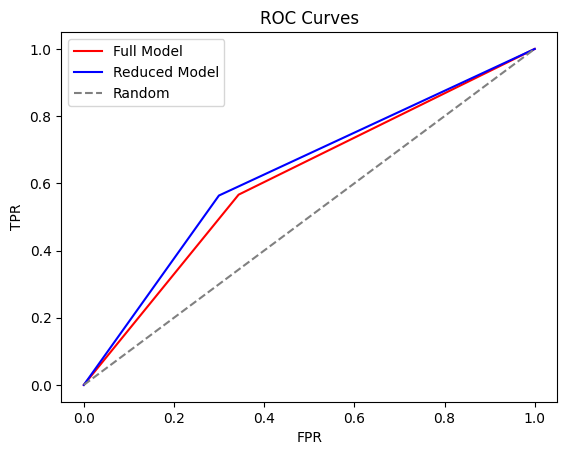

In [67]:
plt.plot(fpr,tpr, label = 'Full Model', color = 'red')
plt.plot(fpr_r,tpr_r,label = 'Reduced Model', color = 'blue')
plt.plot([0,1],[0,1], label = 'Random', linestyle = '--', color = 'grey')

plt.title('ROC Curves')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show